# NN BASELINE

### In this notebook, the input is reshaped into 2D matrices, and a network with multi-attention and bidirectional LSTM is used.

The way to use this notebooks is this:
- Set train and predict to True and run the notebook.
- Look at the  output and add the model to a dataset.
- Add the dataset to the notebook.
- To validate or submit predictions to comepetition:
    - To validate: Set train to False, predict to True and load the model from your dataset.
    - To submit: The same as to validate but using the ONLY_TEST option (if not,  also local cv  validation is done so train data is loaded and you get memory error when submiting to competition).

In [1]:
import os

from google.colab import drive

In [2]:
INIT=True
PATH="/content"

In [3]:
if INIT:
  drive.mount('/content/drive')
  ! pip install kaggle

  !mkdir ~/.kaggle


  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json

  ! kaggle competitions download child-mind-institute-detect-sleep-states
  ! unzip -o child-mind-institute-detect-sleep-states.zip -d   child-mind-institute-detect-sleep-states

  ! kaggle datasets download -d mpp1998/zzz-data-train
  ! unzip -o  zzz-data-train.zip -d    zzz-data-train

  ! kaggle datasets download -d mpp1998/zzz-data-train4
  ! unzip -o  zzz-data-train4.zip -d    zzz-data-train4

  ! kaggle datasets download -d carlmcbrideellis/zzzs-lightweight-training-dataset-target
  ! unzip -o  zzzs-lightweight-training-dataset-target.zip -d    zzzs-lightweight-training-dataset-target

  ! kaggle datasets download -d mpp1998/code-zzz
  ! unzip -o  code-zzz.zip -d    code-zzz

Mounted at /content/drive
100% 810M/811M [00:29<00:00, 32.9MB/s]
100% 811M/811M [00:29<00:00, 29.2MB/s]
Archive:  child-mind-institute-detect-sleep-states.zip
  inflating: child-mind-institute-detect-sleep-states/sample_submission.csv  
  inflating: child-mind-institute-detect-sleep-states/test_series.parquet  
  inflating: child-mind-institute-detect-sleep-states/train_events.csv  
  inflating: child-mind-institute-detect-sleep-states/train_series.parquet  
100% 4.44G/4.44G [03:31<00:00, 26.4MB/s]
100% 4.44G/4.44G [03:31<00:00, 22.5MB/s]
Archive:  zzz-data-train.zip
  inflating: zzz-data-train/data_critic_reg/features.pkl  
  inflating: zzz-data-train/data_critic_reg/steps.pkl  
  inflating: zzz-data-train/data_critic_reg/targets.pkl  
  inflating: zzz-data-train/data_critic_reg_01/features.pkl  
  inflating: zzz-data-train/data_critic_reg_01/steps.pkl  
  inflating: zzz-data-train/data_critic_reg_01/targets.pkl  
  inflating: zzz-data-train/data_critic_reg_10am/features.pkl  
  infla

In [4]:
  ! kaggle datasets download -d mpp1998/zzz-data-train5
  ! unzip -o  zzz-data-train5.zip -d    zzz-data-train5

100% 1.01G/1.01G [00:59<00:00, 16.9MB/s]
100% 1.01G/1.01G [00:59<00:00, 18.2MB/s]
Archive:  zzz-data-train5.zip
  inflating: zzz-data-train5/data_critic_normal01_100/features.pkl  
  inflating: zzz-data-train5/data_critic_normal01_100/steps.pkl  
  inflating: zzz-data-train5/data_critic_normal01_100/targets.pkl  
  inflating: zzz-data-train5/data_critic_normal01_20/features.pkl  
  inflating: zzz-data-train5/data_critic_normal01_20/steps.pkl  
  inflating: zzz-data-train5/data_critic_normal01_20/targets.pkl  


In [5]:
#Copy metrics code from: https://www.kaggle.com/code/metric/event-detection-ap/notebook
!cp /content/code-zzz/evaluation.py .

In [6]:
import glob
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import pickle as pkl
import numpy as np
import logging
import polars as pl
logger=logging.getLogger()
import sys
from tqdm import tqdm
logger.setLevel(logging.INFO)
from tqdm import tqdm
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
if tf.test.is_gpu_available():
    print("TensorFlow está utilizando una GPU.")
    print("GPU utilizada:", tf.test.gpu_device_name())
else:
    print("TensorFlow no está utilizando una GPU.")

import matplotlib.pyplot as plt
import warnings
import joblib
import gc
import pickle as pkl
from itertools import groupby

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow está utilizando una GPU.
GPU utilizada: /device:GPU:0


In [7]:
from evaluation import score

## MODEL TARGET

It is used as the target whether the subject is sleeping or not (1 if they are and 0 if not). There are series with events that have 'step=null'. In these series, there are chunks of data where it is unknown where the previous or next event is. These data points are labeled as 'nan', and will be used only as features since the loss function uses a mask to compute the loss only on data points that do not have a 'nan' target.

Based on this target "sleep", events are constructed for evaluation and final submission using the 'get_event' function, which is being used in other notebooks.







In [8]:
TARGET="sleep"
TEST_IDS = [109,144,106,217,234]

In [9]:
SIGMA=720

## PARAMS

In [10]:
LEARNING_RATE = 0.0005
STEPS_PER_EPOCH = 500
NUM_EPOCHS=14
WARMUP_STEPS = 300
GPU_BATCH_SIZE=32

OPTMIZER_BETA1=0.9
OPTMIZER_BETA2=0.98
OPTMIZER_EPSILON=1e-9

ONLY_TEST = False

## 5 folds in the fold_ids.pkl file (random folds of the 277 train series_ids, this way each full series is only in one fold). In this version only fold1 is used for training the model.
FOLD=1
SAMPLE_NORMALIZE=True

DROP_INITIAL_DATE=True

train=True
predict=True

numeric_features= ["anglez", "enmo"]

CFG = {
   "num_epochs":NUM_EPOCHS,
   "steps_per_epoch":STEPS_PER_EPOCH,
   "patch_size":10,
   "block_size":17280,
   "stride": 17280,
   'model_dim': 160,
   'time_mixing_dim':1440,
   'feature_mixing_dim':160,
   'model_num_heads': 6,
   'model_num_encoder_layers': 5,
   'model_num_lstm_layers': 5,
   'model_first_dropout': 0.5,
   'model_second_dropout':0.5,
   'model_encoder_dropout': 0.1,
   'model_mha_dropout': 0.0,
}
DIM=CFG['patch_size']*2 +2 # 2 numeric features * patch size + 2 more features (sine and cosine of day time)

##  GET AND BUILD DATA

The training data is constructed in another notebook exactly the same way as is test data here:

In [11]:
%%time
if not ONLY_TEST:
    events=pd.read_csv(f"{PATH}/child-mind-institute-detect-sleep-states/train_events.csv")
    events_check=pd.read_csv(f"{PATH}/child-mind-institute-detect-sleep-states/train_events.csv").dropna(subset="timestamp")
    data = pd.read_parquet(f"{PATH}/zzz-data-train/data_train.parquet",columns=["series_id","step","anglez","enmo","minute","sine","cosine","sleep","timestamp"])



CPU times: user 37 s, sys: 13.6 s, total: 50.5 s
Wall time: 37.4 s


In [12]:
data["timestamp"]=pd.to_datetime(data["timestamp"])

In [13]:
## train ids are mapped to int values so we need a dict to map back in the final part to comparare with the events dataset
dict_ids=pkl.load(open(f"{PATH}/zzz-data-train/dict_ids.pkl","rb"))

In [14]:
targets,_,ids = joblib.load("/content/zzz-data-train/train_data.pkl")

In [15]:
targets={dict_ids[ids[i]]:targets[i] for i in range(len(targets))}

In [16]:
ids_=np.load( f"{PATH}/zzz-data-train/ids.npy", allow_pickle=True).reshape(-1)

In [17]:
fold_ids=pkl.load(open(f"{PATH}/zzz-data-train/fold_ids.pkl","rb"))

In [18]:

ids_=list(dict_ids.values())

In [19]:
def sample_normalize(sample):
    mean = tf.math.reduce_mean(sample,axis=0)
    std = tf.math.reduce_std(sample,axis=0)
    sample = tf.math.divide_no_nan(sample-mean, std)

    return sample.numpy()

In [20]:
from pandas.core.arrays.timedeltas import timedelta
def drop_initial_date(df__):

            #df__=df__.drop_duplicates(subset="timestamp")
            #display(df__.loc[(df__.timestamp.diff()==timedelta(seconds=0))])
            df__=df__.loc[~(df__.timestamp.diff()==timedelta(seconds=0))]
            inital_time=df__.iloc[0].timestamp
            #print(inital_time)
            intial_padding = (inital_time.hour*60+inital_time.minute - 60*12)*12
            if intial_padding >0:
              df_ini=pd.DataFrame(np.zeros((intial_padding,9)),columns=df__.columns)
              #print(len(df_ini))
              df_ini["sleep"]=np.nan
              return pd.concat([df_ini,df__])
            else:


              return df__.iloc[-intial_padding:]


In [21]:
def truncate_days(df_,id_):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    swaped_dict={value:key for key , value in dict_ids.items()}
    events_=events_check.loc[events_check.series_id==swaped_dict[id_]]
    events_["timestamp"] =pd.to_datetime(events_["timestamp"].str[:19] )
    prev_lenght=len(df_)
    df_=df_.loc[df_.timestamp.dt.date<= events_.timestamp.dt.date.max()]
    return df_

In [22]:
targets_events=targets

In [23]:
import matplotlib.pyplot as plt
from tensorflow.python.distribute.distribute_lib import def_function
from math import sqrt,exp,pi

In [24]:
def gauss(n=SIGMA,sigma=SIGMA*0.15):
    # guassian distribution function
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

In [25]:
series_=gauss(n=SIGMA,sigma=SIGMA*0.15)

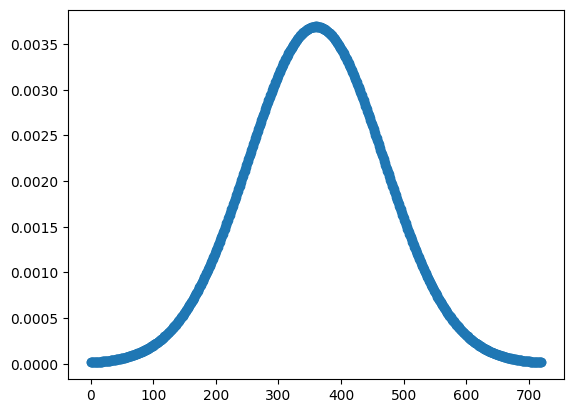

In [26]:
plt.scatter(range(len(series_)),series_)

In [27]:

# Here the data is transformed into samples with shape (CFG[ "block_size"]/CFG["patch_size"],CFG["patch_size"]*num_numeric_features +2). So each sample of the neural network will be 2D with this 2 dimensions.
# Series with lenght  not multiple of CFG[ "block_size"] are padded.

def read_data(data,ids_):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        features={}
        targets={}
        descrp={}
        steps_={}
        for id_ in tqdm(ids_):
            features[id_]=[]
            targets[id_]=[]
            steps_[id_]=[]
            df_=data.loc[data.series_id==id_]
            df_=truncate_days(df_,id_)
            if len(df_)>0:
              if DROP_INITIAL_DATE:
                df_=drop_initial_date(df_)
              #display(df_)
              df__=df_.reset_index()
              steps = range(0,len(df_),CFG["stride"])
              steps= [step for step in steps if step<len(df_)]
              descrp[id_]={"steps":len(steps),"length_df":len(df_)}
              for step in steps:
                  sample_=df_.iloc[step:step+CFG["block_size"],:]
                  feats=sample_.loc[:,numeric_features].values
                  if SAMPLE_NORMALIZE:
                      feats=sample_normalize(feats)
                  sine_=sample_["sine"].values.reshape(-1,1)
                  cosine_=sample_["cosine"].values.reshape(-1,1)
                  target_=np.zeros((len(sample_.loc[:,TARGET].values),2))
                  target_points=targets_events[id_]

                  for s_,e_ in target_points:
                      s= df__.loc[df__.step==s_].index[0]
                      e= df__.loc[df__.step==e_].index[0]
                      #print(s_,e_,s,e)
                      if s>=step and s<step+CFG["block_size"]:
                        s=s-step
                        st1,st2 = max(0,s-SIGMA//2),min(len(  target_),s+SIGMA//2+1)

                        print(f"Added onset {s} in step {step}, affecting interval {st1}:{st2}")
                        target_[st1:st2,0] = gauss()[st1-(s-SIGMA//2):SIGMA+1-((s+SIGMA//2+1)-st2)]
                      if e>=step and e<step+CFG["block_size"]:
                        e=e-step
                        ed1,ed2 = max(0,e-SIGMA//2),min(len(  target_),e+SIGMA//2+1)
                        print(f"Added wakeup {e} in step {step}, affecting interval {ed1}:{ed2}")
                        target_[ed1:ed2,1] = gauss()[ed1-(e-SIGMA//2):SIGMA+1-((e+SIGMA//2+1)-ed2)]

                      gc.collect()
                      if e>step+CFG["block_size"]:
                        print(f"Finished {id_}, step {step+CFG['block_size']}")
                        break
                  target_= target_.reshape(-1,2)
                  if len(feats)<CFG["block_size"]:
                        padding = CFG["block_size"] - len(feats)
                        padding_values = np.zeros((padding, feats.shape[1]))
                        padding_sine = np.zeros((padding, sine_.shape[1]))
                        padding_cosine = np.zeros((padding, cosine_.shape[1]))
                        padding_target = np.empty((padding, 2)) *np.nan
                        feats = np.vstack([feats, padding_values])
                        sine_ = np.vstack([sine_, padding_sine])
                        cosine_ = np.vstack([cosine_, padding_cosine])
                        target_ = np.vstack([target_, padding_target])
                  feats=feats.reshape(-1,CFG["patch_size"]*2).astype(np.float32)
                  sine_=sine_.reshape(-1,CFG["patch_size"],1).mean(axis=1).reshape(-1,1)
                  cosine_=cosine_.reshape(-1,CFG["patch_size"],1).mean(axis=1).reshape(-1,1)
                  targets_=np.nanmean(target_.reshape(-1,CFG["patch_size"],2),axis=1).astype(np.float16)

                  #print(targets_.shape,targets_.max(axis=0),print(targets_[:5]))
                  if max(targets_.max(axis=0))!=0:
                      print(f"MAX IS {max(targets_.max(axis=0))}")
                      features[id_].append(np.concatenate((feats,sine_,cosine_),axis=1))
                      #features[id_].append(feats)

                      targets[id_].append(  targets_)
                      steps_[id_].append(step)
                  else:
                    print("MAX IS 0")

                  del sample_

              del df_
              gc.collect()

        return    features,  targets, descrp,  steps_


def read_data_test(data,ids_):

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        features={}
        descrp={}
        steps_={}
        for id_ in tqdm(ids_):
            features[id_]=[]
            steps_[id_]=[]
            df_=data.loc[data.series_id==id_]
            if DROP_INITIAL_DATE and train==False:
              df_=drop_initial_date(df_)
            steps = range(0,len(df_),CFG["stride"])
            steps= [step for step in steps if step<len(df_)]
            descrp[id_]={"steps":len(steps),"length_df":len(df_)}
            for step in steps:
                sample_=df_.iloc[step:step+CFG["block_size"],:]
                feats=sample_.loc[:,numeric_features].values
                if SAMPLE_NORMALIZE:
                    feats=sample_normalize(feats)
                sine_=sample_["sine"].values.reshape(-1,1)
                cosine_=sample_["cosine"].values.reshape(-1,1)
                if len(feats)<CFG["block_size"]:
                      padding = CFG["block_size"] - len(feats)
                      padding_values = np.zeros((padding, feats.shape[1]))
                      padding_sine = np.zeros((padding, sine_.shape[1]))
                      padding_cosine = np.zeros((padding, cosine_.shape[1]))
                      feats = np.vstack([feats, padding_values])
                      sine_ = np.vstack([sine_, padding_sine])
                      cosine_ = np.vstack([cosine_, padding_cosine])
                feats=feats.reshape(-1,CFG["patch_size"]*2).astype(np.float32)
                sine_=sine_.reshape(-1,CFG["patch_size"],1).mean(axis=1).reshape(-1,1)
                cosine_=cosine_.reshape(-1,CFG["patch_size"],1).mean(axis=1).reshape(-1,1)

                features[id_].append(np.concatenate((feats,sine_,cosine_),axis=1))
                #features[id_].append(feats)

                steps_[id_].append(step)

                del sample_

            del df_
            gc.collect()

        return    features,   descrp,  steps_

In [28]:
%%time
BUILD_DATA=False
if BUILD_DATA:
  if not ONLY_TEST:
      features,  targets, descrp,  steps_ = read_data(data,ids_)
      pkl.dump(features,open("features.pkl","wb"))
      pkl.dump(targets,open("targets.pkl","wb"))
      pkl.dump(steps_,open("steps.pkl","wb"))

  !zip drive/MyDrive/data_critic_reg features.pkl targets.pkl steps.pkl
else:
  features=pkl.load(open("/content/zzz-data-train5/data_critic_normal01_100/features.pkl","rb"))
  targets=pkl.load(open("/content/zzz-data-train5/data_critic_normal01_100/targets.pkl","rb"))
  steps_=pkl.load(open("/content/zzz-data-train5/data_critic_normal01_100/steps.pkl","rb"))

CPU times: user 29.2 ms, sys: 737 ms, total: 766 ms
Wall time: 764 ms


In [29]:
features[0][0].shape

(1728, 22)

In [30]:
id_=0
max_index=targets[id_][0][:,0].argmax()
max_index

628

In [31]:
targets_events[id_][0][0]


5748

In [32]:
df__=data.loc[data.series_id==id_]
df__=drop_initial_date(df__)

In [33]:
df__.iloc[max_index*CFG["patch_size"]:max_index*CFG["patch_size"]+10]

,series_id,step,anglez,enmo,minute,sine,cosine,sleep,timestamp
70518361,0.0,5740.0,-53.495499,0.0716,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:20
70518362,0.0,5741.0,-65.601799,0.0609,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:25
70518363,0.0,5742.0,-56.889900,0.0592,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:30
70518364,0.0,5743.0,-10.045200,0.0583,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:35
70518365,0.0,5744.0,11.183500,0.0095,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:40
70518366,0.0,5745.0,10.241600,0.0035,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:45
70518367,0.0,5746.0,10.207000,0.0032,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:50
70518368,0.0,5747.0,8.890400,0.0087,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:55
70518369,0.0,5748.0,-7.085400,0.1142,1244.0,-0.754710,0.656059,1.0,2018-04-04 20:44:00
70518370,0.0,5749.0,-40.930599,0.0295,1244.0,-0.754710,0.656059,1.0,2018-04-04 20:44:05


In [34]:
CFG["stride"],CFG["block_size"]

(17280, 17280)

In [35]:
ce = tf.keras.losses.BinaryCrossentropy(reduction='none')

def loss_function(real, output, name='loss_function'):

    # a mask is applied to not compute nan target
    mask = tf.math.logical_not(tf.math.is_nan(real))



    y_true = tf.boolean_mask(real, mask)
    y_pred = tf.boolean_mask(output, mask)
    tf.debugging.check_numerics(y_true, message="NaNs in 'real'")
    tf.debugging.check_numerics(y_pred, message="NaNs in 'output'")
    loss = ce(tf.expand_dims(y_true,axis=-1),tf.expand_dims(y_pred,axis=-1))
    tf.debugging.check_numerics(loss, message="NaNs in 'loss'")

    return tf.reduce_mean(loss)





In [36]:
import tensorflow as tf
import logging
logging.basicConfig(level=logging.INFO)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps):
        super(CustomSchedule, self).__init__()
        self.initial_lr = tf.Variable(initial_lr, trainable=False, dtype=tf.float32)
        self.decrease_factor = tf.constant(0.95, dtype=tf.float32)  # Reducir un 5% cada epoch

    def decrease_learning_rate(self):
        if self.initial_lr >=0.000001:
          self.initial_lr.assign(self.initial_lr * self.decrease_factor)

    def __call__(self, step):

        return self.initial_lr

class ReduceLROnThreshold(tf.keras.callbacks.Callback):
    def __init__(self, scheduler, threshold=0.055):
        super(ReduceLROnThreshold, self).__init__()
        self.scheduler = scheduler
        self.threshold = threshold
        self.triggered = False

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss')
        print(self.scheduler.initial_lr)
        if not self.triggered and loss is not None and loss <= self.threshold:
            self.triggered = True
        if self.triggered:
            self.scheduler.decrease_learning_rate()





In [37]:


class Encoder(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.first_linear = tf.keras.layers.Dense(CFG['time_mixing_dim'])
        self.second_linear = tf.keras.layers.Dense(CFG['feature_mixing_dim'])

        self.add = tf.keras.layers.Add()

        self.first_dropout = tf.keras.layers.Dropout(CFG['model_first_dropout'])

        self.second_dropout = tf.keras.layers.Dropout(CFG['model_second_dropout'])





    def call(self, x, training=None):




        features_mixing = self.second_linear(x )

        features_mixing  = tf.keras.layers.ReLU(  )(features_mixing)

        features_mixing   = self.second_dropout( features_mixing )

        x=self.add ([x,features_mixing ])
        return x

class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.encoders = [Encoder() for i in range( CFG['model_num_encoder_layers'])]

        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['model_dim'], return_sequences=True)) for _ in range(CFG['model_num_lstm_layers'])]

        self.first_linear = tf.keras.layers.Dense(CFG['feature_mixing_dim'])
        self.first_dropout = tf.keras.layers.Dropout(0.1)
        self.last_linear = tf.keras.layers.Dense(2)

    def call(self, x):


        x=self.first_linear(x)
        x=self.first_dropout(x)
        for i in range(CFG['model_num_encoder_layers']): x = self.encoders[i](x)

        for i in range(CFG['model_num_lstm_layers']):x= self.lstm_layers[i](x)
        x = self.last_linear(x)
        x = tf.nn.sigmoid(x)
        return x


In [38]:
class MetricsCallback(tf.keras.callbacks.Callback):
  def __init__(self, model=None, verbose=0,FOLD=-1):
    if not model is None: self.model = model
    self.max_score_all=0
    self.max_score_test=0
    self.fold=FOLD
    print(self.fold)

  def prediction(self):
        preds__=model.predict(val_dataset )
        preds__=preds__[:LEN_VAL]
        preds_dict=build_preds_dict(   val_ids,preds__,data,steps_,val_inds,n_data=LEN_VAL)



        events_=get_real_event(   val_ids)


        score_all=get_scores(val_ids,{key:value for key,value in preds_dict.items() if key in val_ids}, events_,smoothing_lengths=[120])


        events_=get_real_event(    TEST_IDS)


        score_test=get_scores(TEST_IDS,{key:value for key,value in preds_dict.items() if key in TEST_IDS}, events_,smoothing_lengths=[120])



        return score_all,score_test


  def on_epoch_end(self, epoch, logs=None):

    score_all,score_test=self.prediction()
    if score_all>=  self.max_score_all:

      print(f"Saving score all: epoch {epoch} because {score_all}>{self.max_score_all}")
      self.model.save_weights(f"model_weights_{epoch}_fold{self.fold}_all")
      self.max_score_all=score_all
    if score_test>=  self.max_score_test:

      print(f"Saving just test: epoch {epoch} because {score_test}>{self.max_score_test}")
      self.model.save_weights(f"model_weights_{epoch}_fold{self.fold}_test")
      self.max_score_test=score_test


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "my_model_weights_checkpoint",  # Filepath to save the checkpoint
    save_best_only=True,  # Save only the best model (optional)
    save_weights_only=True,  # Save only the model weights, not the entire model (optional)
    monitor="val_loss",  # Metric to monitor (e.g., validation loss)
    mode="min",  # "min" or "max" depending on the metric being monitored
    verbose=1  # Verbosity level (optional)
)

In [39]:
def metrics(real,preds__):
    f__=loss_function(real,preds__)
    umbral=0.5
    preds_b=(preds__>umbral).astype(int)
    real__=real.reshape(-1)
    preds_b__=preds_b.reshape(-1)
    cm = confusion_matrix(real__[~np.isnan(real__)], preds_b__[~np.isnan(real__)])
    score,accuracy = f1_score(real__[~np.isnan(real__)], preds_b__[~np.isnan(real__)]), accuracy_score(real__[~np.isnan(real__)], preds_b__[~np.isnan(real__)])
    print(f"Loss: {f__}, cm: {cm}, f1-score: {score}, accuracy: {accuracy}")
def get_real_event(val_ids):
    events=pd.read_csv(f"{PATH}/child-mind-institute-detect-sleep-states/train_events.csv")
    events["series_id"]=events["series_id"].transform(lambda x:dict_ids[x])
    events=events.loc[events.series_id.isin(val_ids)]
    return events

def build_preds_dict(val_ids,preds__,data,steps_,val_inds,n_data):
    preds_dict={}
    for i, id_ in enumerate(val_ids):
        preds_dict[id_]=[]
        df_=data.loc[data.series_id==id_]
        df_=truncate_days(df_,id_)
        if len(df_)>0:
          if DROP_INITIAL_DATE:
                        df_=drop_initial_date( df_)

          l=0



          step_=0
          for l,k in enumerate(val_inds[:n_data]):

              if k["i"]==i:
                  while step_ not in steps_[id_]:
                      preds_dict[id_].append(np.empty((int(CFG["block_size"]/CFG["patch_size"]),2))*np.nan)
                      step_+=CFG["block_size"]
                  if len(preds__)>l:
                      preds_dict[id_].append(preds__[l])



                  step_+=CFG["block_size"]

          if len(preds_dict[id_])>0:
              preds_dict[id_]=np.stack(preds_dict[id_])

              preds_dict[id_]= preds_dict[id_].reshape( preds_dict[id_].shape[1]*preds_dict[id_].shape[0], preds_dict[id_].shape[2])

    return preds_dict

def get_event(df,col="pred"):
        lstCV = zip(df.series_id, df[col])
        lstPOI = []
        for (c, v), g in groupby(lstCV, lambda cv:
                                (cv[0], cv[1]!=0 and not pd.isnull(cv[1]))):
            llg = sum(1 for item in g)
            if v is False:
                lstPOI.extend([0]*llg)
            else:
                lstPOI.extend(['onset']+(llg-2)*[0]+['wakeup'] if llg > 1 else [0])
        return lstPOI

def get_scores(val_ids,preds_dict,events,smoothing_lengths=[120]):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores_=[]

        for smoothing_length in smoothing_lengths:
            events_detected={}
            solution=[]


            for id_ in val_ids:
                if len(preds_dict[id_])>0:
                    events_=events.loc[events.series_id==id_].dropna(subset="timestamp")
                    solution.append(events_)

            solution=pd.concat(solution) .reset_index(drop=True)
            submision=get_preds_df( val_ids,preds_dict,data,smoothing_length=smoothing_length  )
            tolerances= {"onset":[12, 36, 60, 90, 120, 150, 180, 240, 300, 360],"wakeup":[12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
            score_=score(solution,submision,tolerances,    series_id_column_name="series_id",time_column_name="step",event_column_name="event", score_column_name="score" )
            print(smoothing_length, score_)
            scores_.append(score_)
        return np.mean(scores_)


def get_events(data_,idx,pred,min_interval=30) :



  test_ds=data_




  days = len(pred)/(17280/12)

  submission=pd.DataFrame(columns=["step",	"event",	"series_id",	"score"])
  candidates_onset = np.argsort(-pred[:,0])
  candidates_wakeup =  np.argsort(-pred[:,1])
  n_add=max(1,round(days))

  added_onset=[]
  added_wakeup=[]
  disponibles=list(candidates_onset.copy())
  while len(added_onset)<n_add and len(disponibles)>0:
      actual = disponibles.pop(0)
      added_onset.append(actual)
      disponibles = [x for x in disponibles if abs(x - actual) >= min_interval]

  disponibles=list(candidates_wakeup.copy())
  while len( added_wakeup)<n_add and len(disponibles)>0:
      actual = disponibles.pop(0)
      added_wakeup.append(actual)
      disponibles = [x for x in disponibles if abs(x - actual) >= min_interval]
  added_onset=np.array(  added_onset)
  added_wakeup=np.array(    added_wakeup)
  onset = test_ds[['step']].iloc[np.clip(added_onset*CFG["patch_size"],0,len( test_ds)-1)].astype(np.int32)
  onset['event'] = 'onset'
  onset['series_id'] =  idx
  onset['score']= pred[added_onset,0]
  wakeup = test_ds[['step']].iloc[np.clip(added_wakeup*CFG["patch_size"],0,len( test_ds)-1)].astype(np.int32)
  wakeup['event'] = 'wakeup'
  wakeup['series_id'] = idx
  wakeup['score']= pred[added_wakeup,1]
  submission = pd.concat([submission,onset,wakeup],axis=0)

  return submission
def get_preds_df( val_ids,preds_dict,data,smoothing_length=480 ):
    submision=[]
    for id_ in tqdm(val_ids):
                if len(preds_dict[id_])>0:

                    preds=preds_dict[id_]

                    df_=data.loc[data.series_id==id_]
                    df_=truncate_days(df_,id_)
                    data_=df_
                    if DROP_INITIAL_DATE  and not  len(data)==450:
                      data_=drop_initial_date(data_)




                    submision.append(get_events(data_,id_,preds))
    submision= pd.concat(submision)
    submision["step"]=submision["step"].astype(np.float32)
    return submision

In [40]:
CFG, LEARNING_RATE,GPU_BATCH_SIZE

({'num_epochs': 14,
  'steps_per_epoch': 500,
  'patch_size': 10,
  'block_size': 17280,
  'stride': 17280,
  'model_dim': 160,
  'time_mixing_dim': 1440,
  'feature_mixing_dim': 160,
  'model_num_heads': 6,
  'model_num_encoder_layers': 5,
  'model_num_lstm_layers': 5,
  'model_first_dropout': 0.5,
  'model_second_dropout': 0.5,
  'model_encoder_dropout': 0.1,
  'model_mha_dropout': 0.0},
 0.0005,
 32)

In [41]:


file = f'{PATH}/zzzs-lightweight-training-dataset-target/Zzzs_train_multi.parquet'
series_id  = pd.read_parquet(file, columns=['series_id'])
series_id = series_id.series_id.unique()
swaped_dict={val:key for key,val in dict_ids.items()}


In [42]:
def get_inds(train_ids,val_ids):
    arr=np.array(list(features.keys()))
    np.random.shuffle(arr)
    arr=[e for e in arr if e  in train_ids]
    i=0
    inds=[]
    while len(inds)<1_000_000:
        if len(features[arr[i]])>0:
            j=np.random.choice(range(len(features[arr[i]])))
            inds.append({"i":i,"j":j})

        i=i+1
        i=i%len(arr)

    val_inds=[]
    for i,e in enumerate(val_ids):
        for j in range(len(features[e])):
            val_inds.append({"i":i,"j":j})



    return inds,val_inds,arr


In [43]:
def read_indices(row):
    def get_row(i,j):
            return features[arr[i]][j],targets[arr[i]][j]
    series_input, series_target = tf.py_function(get_row, [row['i'], row['j']],[tf.float32, tf.float32])
    series_input.set_shape(shape=(CFG['block_size'] // CFG['patch_size'], DIM))
    series_target.set_shape(shape=(CFG['block_size'] // CFG['patch_size'], 2))
    return    series_input,series_target

def read_val_indices(row):
    def get_row(i,j):
            return features[val_ids[i]][j],targets[val_ids[i]][j]
    series_input, series_target = tf.py_function(get_row, [row['i'], row['j']],[tf.float32, tf.float32])
    series_input.set_shape(shape=(CFG['block_size'] // CFG['patch_size'], DIM))
    series_target.set_shape(shape=(CFG['block_size'] // CFG['patch_size'], 2))
    return    series_input,series_target



In [44]:
id_=0
j=0
targets[id_][j].shape
df_=data.loc[data.series_id==id_]
df_=truncate_days(df_,id_)
df_=drop_initial_date( df_)

In [45]:
df_.iloc[targets[id_][j][:,0].argmax()*10:targets[id_][j][:,0].argmax()*10+10]

,series_id,step,anglez,enmo,minute,sine,cosine,sleep,timestamp
70518361,0.0,5740.0,-53.495499,0.0716,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:20
70518362,0.0,5741.0,-65.601799,0.0609,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:25
70518363,0.0,5742.0,-56.889900,0.0592,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:30
70518364,0.0,5743.0,-10.045200,0.0583,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:35
70518365,0.0,5744.0,11.183500,0.0095,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:40
70518366,0.0,5745.0,10.241600,0.0035,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:45
70518367,0.0,5746.0,10.207000,0.0032,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:50
70518368,0.0,5747.0,8.890400,0.0087,1243.0,-0.757565,0.652760,0.0,2018-04-04 20:43:55
70518369,0.0,5748.0,-7.085400,0.1142,1244.0,-0.754710,0.656059,1.0,2018-04-04 20:44:00
70518370,0.0,5749.0,-40.930599,0.0295,1244.0,-0.754710,0.656059,1.0,2018-04-04 20:44:05


In [46]:
targets[id_][j][:,0].argmax(),targets[id_][j].shape

(628, (1728, 2))

In [ ]:
difs=[]
for i in range(100):
  for j in range(len(features[i])):
    out=model.predict(tf.expand_dims(features[i][j],axis=0))
    #plt.figure()
    #plt.plot(tf.reshape(    targets[i][0], (CFG['block_size'] //2,2, 2))[:,:,0])
    #plt.plot(out[0,:,0])
    #print(targets[i][0][:,0].argmax()-out[0,:,0].argmax()*2)
    #plt.show()
    difs.append(abs(targets[i][j][:,1].argmax()-out[0,:,1].argmax()))

In [ ]:
np.quantile(difs,0.75)

In [48]:
for FOLD in range(5):
  # use just one fold for trainin. only this fold is used to train the final model to submit to competition, so improving here is a must.
  train_ids=[e for e in fold_ids[FOLD][0] if e not in TEST_IDS]
  val_ids=[e for e in fold_ids[FOLD][1] if e not in TEST_IDS]+TEST_IDS


  print(len(train_ids)),print(len(val_ids))

  inds,val_inds,arr= get_inds(train_ids,val_ids)
  print(len(inds),len(val_inds))


  LEN_VAL= len(val_inds)
  REMAINDER_VAL=(GPU_BATCH_SIZE - len(val_inds)%GPU_BATCH_SIZE)%GPU_BATCH_SIZE
  print(f"Remainder validation {REMAINDER_VAL}")

  for i in range(REMAINDER_VAL):
      val_inds.append(val_inds[-1])




  dataset =tf.data.Dataset.from_tensor_slices(dict(pd.DataFrame(inds)))
  dataset = dataset .map(read_indices).batch( GPU_BATCH_SIZE, drop_remainder=False)


  val_dataset =tf.data.Dataset.from_tensor_slices(dict(pd.DataFrame(val_inds)))

  val_dataset = val_dataset .map(read_val_indices).batch( GPU_BATCH_SIZE, drop_remainder=False)


  ## same as val_dataset but with batch size 1 to prediction
  val_dataset_backup=tf.data.Dataset.from_tensor_slices(dict(pd.DataFrame(val_inds[:LEN_VAL])))
  val_dataset__=val_dataset_backup .map(read_val_indices).batch( 1, drop_remainder=False)

  len(val_ids)





  model=Model()
  scheduler=CustomSchedule(LEARNING_RATE, WARMUP_STEPS)
  optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler, beta_1=OPTMIZER_BETA1, beta_2=OPTMIZER_BETA2, epsilon=OPTMIZER_EPSILON)
  model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'],DIM ))

  model.compile(optimizer=optimizer,loss=loss_function)
  #model.  summary()

  model.fit(dataset,epochs= 10,steps_per_epoch=CFG["steps_per_epoch"],validation_data=val_dataset, callbacks=[MetricsCallback(FOLD=FOLD),])
  model.save_weights("my_model_weights")

217
60
1000000 1115
Remainder validation 5
0
Epoch 1/10
35/35 [==============================] - 13s 277ms/step


100%|██████████| 60/60 [01:03<00:00,  1.06s/it]


120 0.00037031858935473094


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


120 0.0012311241469529005
Saving score all: epoch 0 because 0.00037031858935473094>0
Saving just test: epoch 0 because 0.0012311241469529005>0
500/500 [==============================] - 531s 1s/step - loss: 0.0037 - val_loss: 0.0014
Epoch 2/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


120 0.6977789077288163


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


120 0.5613102891716073
Saving score all: epoch 1 because 0.6977789077288163>0.00037031858935473094
Saving just test: epoch 1 because 0.5613102891716073>0.0012311241469529005
500/500 [==============================] - 502s 1s/step - loss: 0.0011 - val_loss: 8.0753e-04
Epoch 3/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 60/60 [01:01<00:00,  1.03s/it]


120 0.7357455976825782


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


120 0.5878825237878162
Saving score all: epoch 2 because 0.7357455976825782>0.6977789077288163
Saving just test: epoch 2 because 0.5878825237878162>0.5613102891716073
500/500 [==============================] - 501s 1s/step - loss: 7.6770e-04 - val_loss: 7.6265e-04
Epoch 4/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


120 0.7521284976195537


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


120 0.6055238619663698
Saving score all: epoch 3 because 0.7521284976195537>0.7357455976825782
Saving just test: epoch 3 because 0.6055238619663698>0.5878825237878162
500/500 [==============================] - 501s 1s/step - loss: 7.4390e-04 - val_loss: 7.6008e-04
Epoch 5/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


120 0.7742344371911005


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


120 0.6141540626682491
Saving score all: epoch 4 because 0.7742344371911005>0.7521284976195537
Saving just test: epoch 4 because 0.6141540626682491>0.6055238619663698
500/500 [==============================] - 501s 1s/step - loss: 7.3265e-04 - val_loss: 7.5342e-04
Epoch 6/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 60/60 [01:01<00:00,  1.03s/it]


120 0.7693901930523832


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


120 0.6143443300160298
Saving just test: epoch 5 because 0.6143443300160298>0.6141540626682491
500/500 [==============================] - 500s 1s/step - loss: 7.2170e-04 - val_loss: 7.5992e-04
Epoch 7/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 60/60 [01:01<00:00,  1.03s/it]


120 0.7681555981227979


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


120 0.6157072650448426
Saving just test: epoch 6 because 0.6157072650448426>0.6143443300160298
500/500 [==============================] - 501s 1s/step - loss: 7.1197e-04 - val_loss: 7.6132e-04
Epoch 8/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


120 0.7568958736381743


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


120 0.5902062013474145
500/500 [==============================] - 501s 1s/step - loss: 6.9689e-04 - val_loss: 7.6287e-04
Epoch 9/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 60/60 [01:01<00:00,  1.02s/it]


120 0.7584840044397766


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


120 0.5907276750129364
500/500 [==============================] - 500s 1s/step - loss: 6.8023e-04 - val_loss: 7.7652e-04
Epoch 10/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 60/60 [01:01<00:00,  1.03s/it]


120 0.7183614125100899


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


120 0.5474934768643799
500/500 [==============================] - 500s 1s/step - loss: 6.9441e-04 - val_loss: 7.9055e-04
217
60
1000000 1027
Remainder validation 29
1
Epoch 1/10
33/33 [==============================] - 12s 277ms/step


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


120 0.00012641589497737452


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


120 0.0028739679885584277
Saving score all: epoch 0 because 0.00012641589497737452>0
Saving just test: epoch 0 because 0.0028739679885584277>0
500/500 [==============================] - 533s 1s/step - loss: 0.0039 - val_loss: 0.0014
Epoch 2/10
33/33 [==============================] - 9s 278ms/step


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


120 0.6853669297876844


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


120 0.5802017993061805
Saving score all: epoch 1 because 0.6853669297876844>0.00012641589497737452
Saving just test: epoch 1 because 0.5802017993061805>0.0028739679885584277
500/500 [==============================] - 513s 1s/step - loss: 0.0010 - val_loss: 7.8464e-04
Epoch 3/10
33/33 [==============================] - 9s 279ms/step


100%|██████████| 60/60 [01:08<00:00,  1.13s/it]


120 0.7199748933142442


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


120 0.5676997220351746
Saving score all: epoch 2 because 0.7199748933142442>0.6853669297876844
500/500 [==============================] - 511s 1s/step - loss: 7.6388e-04 - val_loss: 7.5832e-04
Epoch 4/10
33/33 [==============================] - 9s 279ms/step


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


120 0.7309710743026114


100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


120 0.6074946597222582
Saving score all: epoch 3 because 0.7309710743026114>0.7199748933142442
Saving just test: epoch 3 because 0.6074946597222582>0.5802017993061805
500/500 [==============================] - 511s 1s/step - loss: 7.4560e-04 - val_loss: 7.4045e-04
Epoch 5/10
33/33 [==============================] - 9s 279ms/step


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


120 0.7472562385198966


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


120 0.6237493708039474
Saving score all: epoch 4 because 0.7472562385198966>0.7309710743026114
Saving just test: epoch 4 because 0.6237493708039474>0.6074946597222582
500/500 [==============================] - 512s 1s/step - loss: 7.3547e-04 - val_loss: 7.3543e-04
Epoch 6/10
33/33 [==============================] - 9s 280ms/step


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


120 0.7451782240799952


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


120 0.6237034240359841
500/500 [==============================] - 511s 1s/step - loss: 7.2536e-04 - val_loss: 7.4147e-04
Epoch 7/10
33/33 [==============================] - 9s 279ms/step


100%|██████████| 60/60 [01:07<00:00,  1.12s/it]


120 0.7419926225782043


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


120 0.6012426994703015
500/500 [==============================] - 511s 1s/step - loss: 7.1781e-04 - val_loss: 7.3668e-04
Epoch 8/10
33/33 [==============================] - 9s 279ms/step


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


120 0.7524674678606227


100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


120 0.600979526096955
Saving score all: epoch 7 because 0.7524674678606227>0.7472562385198966
500/500 [==============================] - 511s 1s/step - loss: 7.0361e-04 - val_loss: 7.4287e-04
Epoch 9/10
33/33 [==============================] - 9s 279ms/step


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


120 0.7452255068449611


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


120 0.5740664755507349
500/500 [==============================] - 514s 1s/step - loss: 6.9468e-04 - val_loss: 7.5447e-04
Epoch 10/10
33/33 [==============================] - 9s 279ms/step


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


120 0.7291476610421104


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


120 0.5552714651872153
500/500 [==============================] - 511s 1s/step - loss: 6.7795e-04 - val_loss: 7.6414e-04
218
59
1000000 987
Remainder validation 5
2
Epoch 1/10
31/31 [==============================] - 12s 278ms/step


100%|██████████| 59/59 [01:01<00:00,  1.05s/it]


120 0.0002787714352003144


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


120 0.0009758321858894083
Saving score all: epoch 0 because 0.0002787714352003144>0
Saving just test: epoch 0 because 0.0009758321858894083>0
500/500 [==============================] - 522s 1s/step - loss: 0.0036 - val_loss: 0.0014
Epoch 2/10
31/31 [==============================] - 9s 279ms/step


100%|██████████| 59/59 [01:01<00:00,  1.04s/it]


120 0.7185642194998478


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


120 0.5768881287323804
Saving score all: epoch 1 because 0.7185642194998478>0.0002787714352003144
Saving just test: epoch 1 because 0.5768881287323804>0.0009758321858894083
500/500 [==============================] - 499s 998ms/step - loss: 9.7173e-04 - val_loss: 7.7185e-04
Epoch 3/10
31/31 [==============================] - 9s 279ms/step


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


120 0.7592192575227144


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


120 0.6039565586566351
Saving score all: epoch 2 because 0.7592192575227144>0.7185642194998478
Saving just test: epoch 2 because 0.6039565586566351>0.5768881287323804
500/500 [==============================] - 498s 997ms/step - loss: 7.6884e-04 - val_loss: 7.4856e-04
Epoch 4/10
31/31 [==============================] - 9s 279ms/step


100%|██████████| 59/59 [01:00<00:00,  1.03s/it]


120 0.7650578717477241


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


120 0.6014640731749586
Saving score all: epoch 3 because 0.7650578717477241>0.7592192575227144
500/500 [==============================] - 498s 996ms/step - loss: 7.4575e-04 - val_loss: 7.4358e-04
Epoch 5/10
31/31 [==============================] - 9s 279ms/step


100%|██████████| 59/59 [01:01<00:00,  1.05s/it]


120 0.7769011651945702


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


120 0.617109379812389
Saving score all: epoch 4 because 0.7769011651945702>0.7650578717477241
Saving just test: epoch 4 because 0.617109379812389>0.6039565586566351
500/500 [==============================] - 499s 998ms/step - loss: 7.3781e-04 - val_loss: 7.4143e-04
Epoch 6/10
31/31 [==============================] - 9s 280ms/step


100%|██████████| 59/59 [01:00<00:00,  1.03s/it]


120 0.77349775079375


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


120 0.6262416808992157
Saving just test: epoch 5 because 0.6262416808992157>0.617109379812389
500/500 [==============================] - 498s 997ms/step - loss: 7.2947e-04 - val_loss: 7.4085e-04
Epoch 7/10
31/31 [==============================] - 9s 280ms/step


100%|██████████| 59/59 [01:01<00:00,  1.04s/it]


120 0.7752238856555074


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


120 0.6321494366312448
Saving just test: epoch 6 because 0.6321494366312448>0.6262416808992157
500/500 [==============================] - 499s 998ms/step - loss: 7.2397e-04 - val_loss: 7.3904e-04
Epoch 8/10
31/31 [==============================] - 9s 279ms/step


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


120 0.7671622853787523


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


120 0.6270085168926967
500/500 [==============================] - 498s 996ms/step - loss: 7.0917e-04 - val_loss: 7.4526e-04
Epoch 9/10
31/31 [==============================] - 9s 279ms/step


100%|██████████| 59/59 [00:59<00:00,  1.02s/it]


120 0.7520756258186918


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


120 0.5915282468386591
500/500 [==============================] - 498s 996ms/step - loss: 6.9280e-04 - val_loss: 7.6664e-04
Epoch 10/10
31/31 [==============================] - 9s 279ms/step


100%|██████████| 59/59 [01:00<00:00,  1.03s/it]


120 0.7542805065506227


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


120 0.6008596829928767
500/500 [==============================] - 499s 998ms/step - loss: 6.8017e-04 - val_loss: 7.7397e-04
218
59
1000000 1255
Remainder validation 25
3
Epoch 1/10
40/40 [==============================] - 14s 278ms/step


100%|██████████| 59/59 [01:28<00:00,  1.49s/it]


120 0.0006875988286432486


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


120 0.0014593510029586169
Saving score all: epoch 0 because 0.0006875988286432486>0
Saving just test: epoch 0 because 0.0014593510029586169>0
500/500 [==============================] - 577s 1s/step - loss: 0.0039 - val_loss: 0.0013
Epoch 2/10
40/40 [==============================] - 11s 278ms/step


100%|██████████| 59/59 [01:29<00:00,  1.52s/it]


120 0.7110048883530432


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


120 0.5779513913764674
Saving score all: epoch 1 because 0.7110048883530432>0.0006875988286432486
Saving just test: epoch 1 because 0.5779513913764674>0.0014593510029586169
500/500 [==============================] - 555s 1s/step - loss: 9.2066e-04 - val_loss: 7.7236e-04
Epoch 3/10
40/40 [==============================] - 11s 279ms/step


100%|██████████| 59/59 [01:28<00:00,  1.50s/it]


120 0.7545746838210909


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


120 0.6230961441685512
Saving score all: epoch 2 because 0.7545746838210909>0.7110048883530432
Saving just test: epoch 2 because 0.6230961441685512>0.5779513913764674
500/500 [==============================] - 555s 1s/step - loss: 7.5679e-04 - val_loss: 7.5365e-04
Epoch 4/10
40/40 [==============================] - 11s 278ms/step


100%|██████████| 59/59 [01:28<00:00,  1.51s/it]


120 0.7600592273309881


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


120 0.6178877011410384
Saving score all: epoch 3 because 0.7600592273309881>0.7545746838210909
500/500 [==============================] - 556s 1s/step - loss: 7.4051e-04 - val_loss: 7.4727e-04
Epoch 5/10
40/40 [==============================] - 11s 279ms/step


100%|██████████| 59/59 [01:29<00:00,  1.52s/it]


120 0.7548620466343307


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


120 0.6101563131266795
500/500 [==============================] - 555s 1s/step - loss: 7.2467e-04 - val_loss: 7.4363e-04
Epoch 6/10
40/40 [==============================] - 11s 278ms/step


100%|██████████| 59/59 [01:29<00:00,  1.52s/it]


120 0.757397005079435


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


120 0.5924416939453145
500/500 [==============================] - 555s 1s/step - loss: 7.1430e-04 - val_loss: 7.5195e-04
Epoch 7/10
40/40 [==============================] - 11s 279ms/step


100%|██████████| 59/59 [01:29<00:00,  1.52s/it]


120 0.7484589531232368


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


120 0.5724644909996106
500/500 [==============================] - 558s 1s/step - loss: 7.0396e-04 - val_loss: 7.5618e-04
Epoch 8/10
40/40 [==============================] - 11s 279ms/step


100%|██████████| 59/59 [01:28<00:00,  1.50s/it]


120 0.7516502219466257


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


120 0.590736714119094
500/500 [==============================] - 555s 1s/step - loss: 6.9050e-04 - val_loss: 7.6130e-04
Epoch 9/10
40/40 [==============================] - 11s 279ms/step


100%|██████████| 59/59 [01:28<00:00,  1.51s/it]


120 0.7383458830482206


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


120 0.5942131302061919
500/500 [==============================] - 556s 1s/step - loss: 6.7419e-04 - val_loss: 7.7589e-04
Epoch 10/10
40/40 [==============================] - 11s 279ms/step


100%|██████████| 59/59 [01:28<00:00,  1.51s/it]


120 0.707330435922402


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


120 0.551914287155023
500/500 [==============================] - 555s 1s/step - loss: 6.5827e-04 - val_loss: 8.0441e-04
218
59
1000000 1108
Remainder validation 12
4
Epoch 1/10
35/35 [==============================] - 13s 278ms/step


100%|██████████| 59/59 [01:11<00:00,  1.22s/it]


120 0.0002760281537364981


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


120 0.001369799898339135
Saving score all: epoch 0 because 0.0002760281537364981>0
Saving just test: epoch 0 because 0.001369799898339135>0
500/500 [==============================] - 543s 1s/step - loss: 0.0039 - val_loss: 0.0014
Epoch 2/10
35/35 [==============================] - 10s 278ms/step


100%|██████████| 59/59 [01:12<00:00,  1.22s/it]


120 0.6610708995379782


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


120 0.5581297991658783
Saving score all: epoch 1 because 0.6610708995379782>0.0002760281537364981
Saving just test: epoch 1 because 0.5581297991658783>0.001369799898339135
500/500 [==============================] - 522s 1s/step - loss: 0.0010 - val_loss: 8.1246e-04
Epoch 3/10
35/35 [==============================] - 10s 278ms/step


100%|██████████| 59/59 [01:12<00:00,  1.22s/it]


120 0.7176812128097728


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


120 0.5907392185353538
Saving score all: epoch 2 because 0.7176812128097728>0.6610708995379782
Saving just test: epoch 2 because 0.5907392185353538>0.5581297991658783
500/500 [==============================] - 521s 1s/step - loss: 7.5147e-04 - val_loss: 7.8316e-04
Epoch 4/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 59/59 [01:11<00:00,  1.22s/it]


120 0.7283078945949064


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


120 0.5863354407134865
Saving score all: epoch 3 because 0.7283078945949064>0.7176812128097728
500/500 [==============================] - 521s 1s/step - loss: 7.3577e-04 - val_loss: 7.8116e-04
Epoch 5/10
35/35 [==============================] - 10s 278ms/step


100%|██████████| 59/59 [01:12<00:00,  1.23s/it]


120 0.7275360764805479


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


120 0.5905499424305596
500/500 [==============================] - 521s 1s/step - loss: 7.2520e-04 - val_loss: 7.8110e-04
Epoch 6/10
35/35 [==============================] - 10s 278ms/step


100%|██████████| 59/59 [01:11<00:00,  1.21s/it]


120 0.7377235984800592


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


120 0.5966495403157626
Saving score all: epoch 5 because 0.7377235984800592>0.7283078945949064
Saving just test: epoch 5 because 0.5966495403157626>0.5907392185353538
500/500 [==============================] - 520s 1s/step - loss: 7.1533e-04 - val_loss: 7.7465e-04
Epoch 7/10
35/35 [==============================] - 10s 278ms/step


100%|██████████| 59/59 [01:11<00:00,  1.21s/it]


120 0.7364732285512869


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


120 0.6058699060549562
Saving just test: epoch 6 because 0.6058699060549562>0.5966495403157626
500/500 [==============================] - 520s 1s/step - loss: 7.0647e-04 - val_loss: 7.8409e-04
Epoch 8/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 59/59 [01:11<00:00,  1.22s/it]


120 0.7348343706595631


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


120 0.5933153890227434
500/500 [==============================] - 520s 1s/step - loss: 6.9503e-04 - val_loss: 7.8576e-04
Epoch 9/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 59/59 [01:12<00:00,  1.22s/it]


120 0.7269408999341124


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


120 0.5747444486020321
500/500 [==============================] - 521s 1s/step - loss: 6.8276e-04 - val_loss: 7.9421e-04
Epoch 10/10
35/35 [==============================] - 10s 279ms/step


100%|██████████| 59/59 [01:12<00:00,  1.24s/it]


120 0.7241533468350339


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


120 0.5851064613931638
500/500 [==============================] - 523s 1s/step - loss: 6.6927e-04 - val_loss: 8.1836e-04


In [50]:
import glob
files= glob.glob("model_weights_*da*")
files.sort()
for fold in range(5):
  files_fold=[]
  for file in files:
    if file.split("_")[3]=="fold"+str(fold):
      files_fold.append(file)


  files_fold.sort()
  file_=[e for e in files_fold if "test" in e][-1]
  print(file_)
  !zip drive/MyDrive/{file_.replace('data-00000-of-00001','')+"_normal01_100"} {file_} {file_.replace('data-00000-of-00001','index')}
  file_=[e for e in files_fold if "all" in e][-1]
  print(file_)
  !zip drive/MyDrive/{file_.replace('data-00000-of-00001','')+"_normal01_100"} {file_} {file_.replace('data-00000-of-00001','index')}

model_weights_6_fold0_test.data-00000-of-00001
  adding: model_weights_6_fold0_test.data-00000-of-00001 (deflated 6%)
  adding: model_weights_6_fold0_test.index (deflated 75%)
model_weights_4_fold0_all.data-00000-of-00001
  adding: model_weights_4_fold0_all.data-00000-of-00001 (deflated 6%)
  adding: model_weights_4_fold0_all.index (deflated 75%)
model_weights_4_fold1_test.data-00000-of-00001
  adding: model_weights_4_fold1_test.data-00000-of-00001 (deflated 6%)
  adding: model_weights_4_fold1_test.index (deflated 75%)
model_weights_7_fold1_all.data-00000-of-00001
  adding: model_weights_7_fold1_all.data-00000-of-00001 (deflated 6%)
  adding: model_weights_7_fold1_all.index (deflated 75%)
model_weights_6_fold2_test.data-00000-of-00001
  adding: model_weights_6_fold2_test.data-00000-of-00001 (deflated 6%)
  adding: model_weights_6_fold2_test.index (deflated 75%)
model_weights_4_fold2_all.data-00000-of-00001
  adding: model_weights_4_fold2_all.data-00000-of-00001 (deflated 6%)
  adding: 